# This notebook shows that limb darkening should be a secondary effect in our sample

Note that this could be different if the flaring area was huge (filling fraction above 0.1)

In [1]:
# get model functions to experiment with
from funcs.model import dot_ensemble_spherical, aflare, daylength, on_off, lambert
from funcs.helper import no_nan_inf



def limb(x, u):
    """Linear limb darkening with coefficient u and angle x."""
    return 1 - (1 - np.cos(x)) * u 

/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
NumExpr defaulting to 8 threads.


In [2]:
# basics
import numpy as np
import pandas as pd

# matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib 
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 

font = {'family' : 'courier',
        'weight' : 'normal',
        'size'   : 15}

matplotlib.rc('font', **font)

from matplotlib.lines import Line2D

In [12]:
# add linear limb darkening as keyword "u" to function from model

def lightcurve_model(phi, latitudes, longitudes, flare, inclination, phi0=0., u=1.):
    """Take a flare light curve and a rotating ensemble of latitudes
    and longitudes, and let it rotate.

    Parameters:
    -----------
    phi :  N-array
        longitudes to evaluate the model at in rad
    latitudes : M-array
        latitudes of the spot grid points in rad
    longitudes : M-array
        longitudes of the spot grid points in rad
    flare : N-array
        flare shape
    inclination : float
        inclination in rad
    phi0 : float
        longitude facing the observer

    Return:
    --------
    lambert modifier for flux - N-array
    onoff day and night step function - N-array
    model light curve - N-array
    """

    if no_nan_inf([phi, latitudes, longitudes, flare, inclination, phi0]) == False:
        raise ValueError("One of your inputs in model() is or contains NaN or Inf.")

    # Check if the dimensions of the inputs are right
    l = len(latitudes)
    assert l == len(longitudes)
    assert len(phi) == len(flare)
    # -----------------------------------------------

    # Mould phi0 into -pi:pi range

    phi0 = phi0 % (2*np.pi)


    # Get daylengths for all grid points
    # and calculate day/night switches:
    Ds = daylength(latitudes, inclination)
    onoff = np.full((l,phi.shape[0]),0)

    for i,(d,lon) in enumerate(zip(Ds,longitudes)):# How can I avoid this loop?
        onoff[i,:] = on_off(phi-lon, d, phi0=phi0)
    #------------------------------------------------

    # Why isn't it possible to just fill an array here?
    # Refactor later ...
    # Anyways: Calculate the lambert modifier:
    latlon = np.concatenate((latitudes.reshape(l,1),
                             longitudes.reshape(l,1)),
                            axis=1)
    A, Q = [], []
    for i, ll in enumerate(latlon):
        a = lambert(phi-ll[1], inclination, ll[0], phi0=phi0)
#         print(np.arccos(a) * 180 / np.pi)
        q = limb(np.arccos(a), u)
        Q.append(q)
        A.append(a)
    lamb = np.array(A)
    covered = np.sum(np.array(Q) * onoff, axis=0) / l
#     print(covered)

    #--------------------------------------------------

    # Give intermediate results: lamb, onoff
    # Also co-add all grid points and average them
    # after folding with flare:
    return lamb, onoff, np.sum(lamb * onoff, axis=0) * flare / l, covered

### Plot limb darkening effect

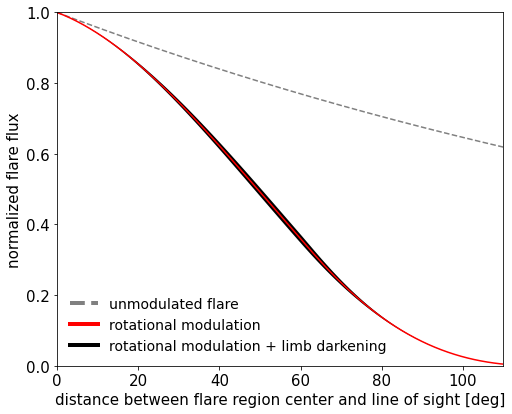

In [13]:
# choose angular radius
ang_rad = 30

# total number of data points on one hemisphere
from funcs.model import PHI 
total = len(PHI) // 2

# array of distances to the limb
x = np.linspace(0,np.pi/2 + np.pi/8,140)

# convert to degrees
deg = x / np.pi * 180.

# some slow-ish flare decay  (1 e-folding per rotation)
y = 1 * np.exp(-.25 * x)

# Start figure
plt.figure(figsize=(8,6.5))

# plot unmodulated flare
plt.plot(deg, y, c="grey", linestyle="dashed")

# create spherical cap flaring region
latitudes, longitudes = dot_ensemble_spherical(0,0,ang_rad)


# loop over limb darkening coefficients
fs = []
for _ in [0.5,1,1.5]:

    # model light curve, esp. lambert factor and visibility with limb darkening:
    lamb, onoff, m, covered = lightcurve_model(x, latitudes, -longitudes, y, np.pi/2, u=_) 

    # get the number of data points covered by the flaring region 
    # relative to the total number of data points on the surface
    s = np.sum(onoff, axis=0) / total

    # flux amplitude divided by adjusted background flux, i.e. 
    # 1 - s * covered <-> total flux - limb darkened spot that occupies fraction s of the total flux
    flux =   m / (1 - s * covered)

    fs.append(flux/flux[0])

# plot with u=1, that is, no limb darkening
plt.plot(deg, fs[1], c="r")

# plot the range of limb darkening coefficients applied to the light curve
plt.fill_between(deg, fs[2] , fs[0], label=ang_rad,  facecolor="k")

# layout
legend_elements3 = [Line2D([0], [0], color='grey', lw=4, linestyle="dashed", 
                      label="unmodulated flare"),
                Line2D([0], [0], color='r', lw=4, 
                      label=f"rotational modulation"),
                Line2D([0], [0], color='k', lw=4, 
                      label=f"rotational modulation + limb darkening"),]

plt.legend(handles=legend_elements3, fontsize=14, frameon=False, loc=3)

plt.ylim(0,1)
plt.xlim(0,110)
plt.xlabel("distance between flare region center and line of sight [deg]")
plt.ylabel("normalized flare flux")
plt.savefig("/home/ekaterina/Documents/002_writing/multiperiod-flares-draft-mnras/figures/appendix_limb_darkening.png", dpi=300);
   